In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%run ./split_step_fourier.ipynb

# showing figures inline
%matplotlib inline
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

Text(0.5, 1.0, 'Impulse Responses')

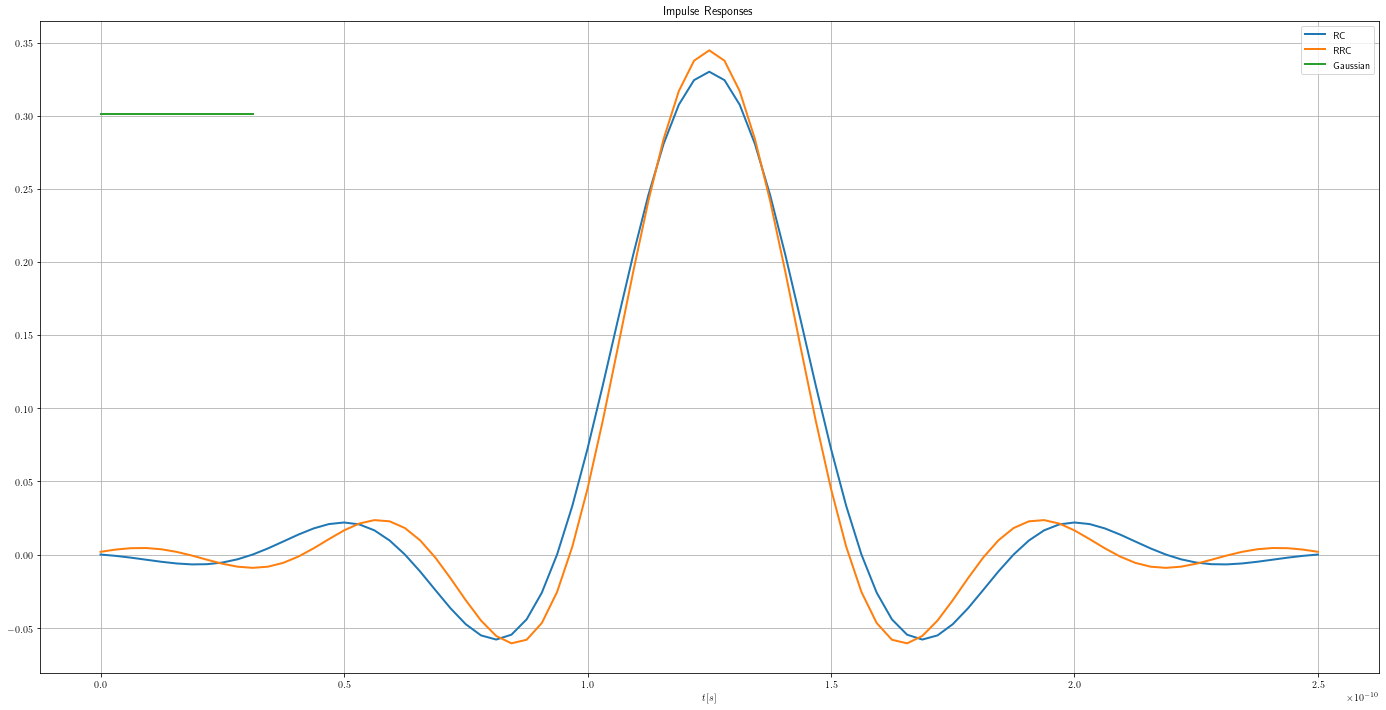

In [59]:
# parameters of the filters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10 # samples per symbol (>1 => oversampling)

r_rc = .33
r_rrc = .33
r_gaussian = 0.8

syms_per_filt = 4  # symbols per filter (plus minus in both directions)

t_sample_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)
t_sample_rrc, rrc = get_rrc_ir(syms_per_filt, r_rrc, f_symbol, n_up)
t_sample_gaussian, gaussian = get_gaussian_ir(r_gaussian, f_symbol, n_up)

matplotlib.rc('figure', figsize=(24, 12) )

plt.plot(np.arange(rc.size)*t_sample_rc, rc, linewidth=2.0, label='RC')
plt.plot(np.arange(rrc.size)*t_sample_rrc, rrc, linewidth=2.0, label='RRC')
plt.plot(np.arange(gaussian.size)*t_sample_gaussian, gaussian, linewidth=2.0, label='Gaussian')

plt.grid( True )
plt.legend( loc='upper right' )
plt.xlabel('$t[s]$')
plt.title( 'Impulse Responses' )

Text(0.5, 1.0, 'Impulse Responses')

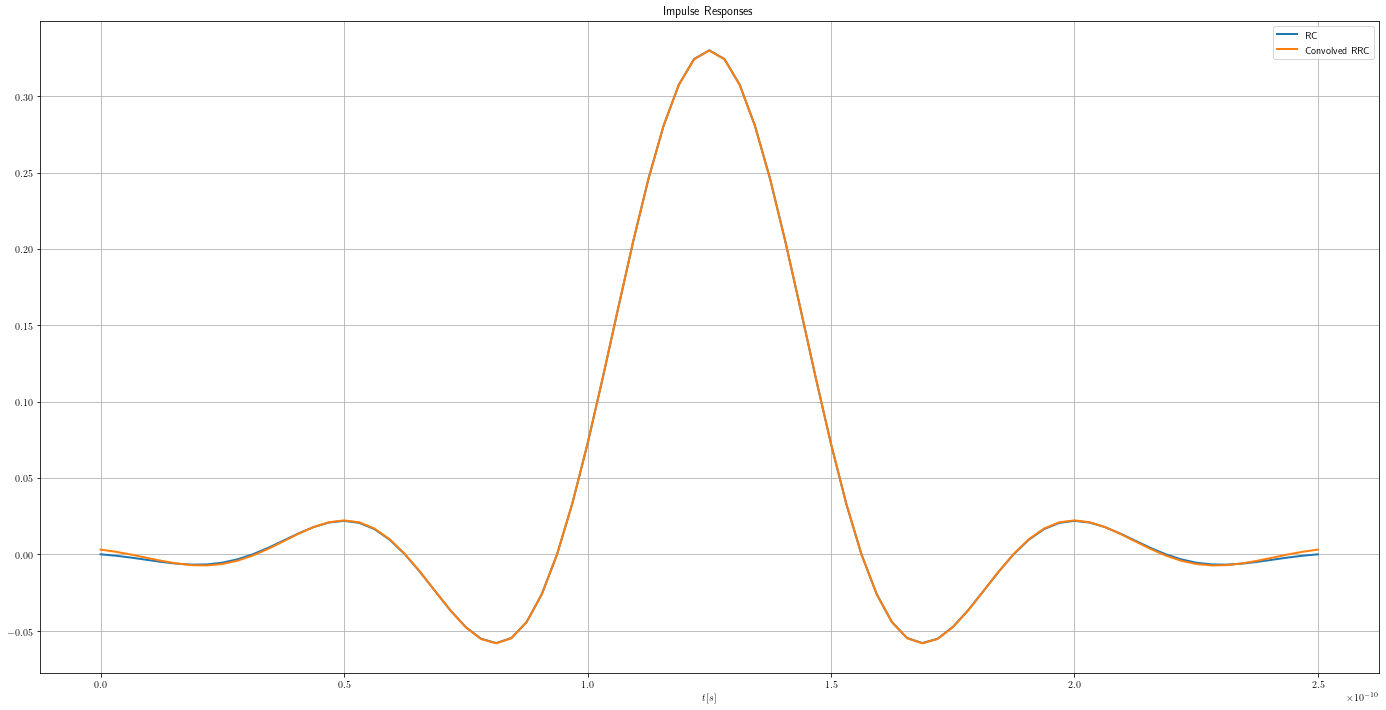

In [60]:
# Comparison of convolved rrc with rc

t_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)
t_rrc, rrc = get_rrc_ir(syms_per_filt, r_rrc, f_symbol, n_up)

rrc_convolved = np.convolve(rrc, rrc, mode='same')
rrc_convolved /= np.linalg.norm(rrc_convolved)

matplotlib.rc('figure', figsize=(24, 12))

plt.plot(np.arange(rc.size)*t_sample_rc, rc , linewidth=2.0, label='RC')
plt.plot(np.arange(rrc_convolved.size)*t_sample_rrc, rrc_convolved, linewidth=2.0, label='Convolved RRC')

plt.grid( True )
plt.legend(loc='upper right')
plt.xlabel('$t[s]$')
plt.title('Impulse Responses')


Text(0.5, 1.0, 'Modulation Gaus')

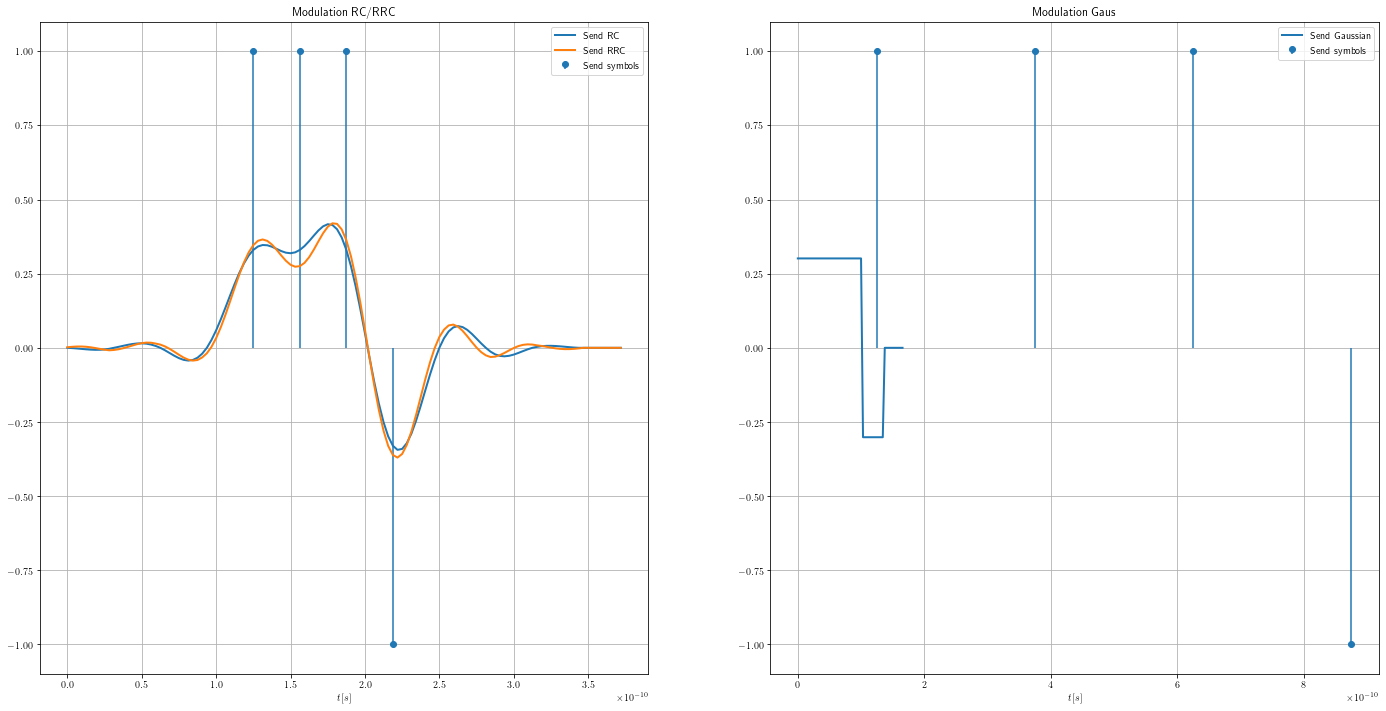

In [76]:
# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}
n_symbol = 4 # number of symbols

# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)

send_rc = generate_signal(modulation, send_bits, rc, syms_per_filt)
send_rrc = generate_signal(modulation, send_bits, rrc, syms_per_filt)
send_gaussian = generate_signal(modulation, send_bits, gaussian, 0)

matplotlib.rc('figure', figsize=(24, 12) )

plt.subplot(121)
plt.plot(np.arange(send_rc.size)*t_sample_rc, send_rc, linewidth=2.0, label='Send RC')
plt.plot(np.arange(send_rrc.size)*t_sample_rrc, send_rrc, linewidth=2.0, label='Send RRC')
plt.stem(np.arange(n_symbol/f_symbol, step=1/f_symbol)+syms_per_filt/f_symbol, [ modulation[str(symbol)] for symbol in send_bits ], label='Send symbols', use_line_collection=True, basefmt=' ')

plt.grid( True )
plt.ylim(-1.1, 1.1)
plt.xlabel('$t[s]$')
plt.legend(loc='upper right')
plt.title('Modulation RC/RRC')

plt.subplot(122)
plt.plot(np.arange(send_gaussian.size)*t_sample_gaussian, send_gaussian, linewidth=2.0, label='Send Gaussian')
plt.stem(np.arange(8*n_symbol/f_symbol, step=8/f_symbol)+syms_per_filt/f_symbol, [ modulation[str(symbol)] for symbol in send_bits ], label='Send symbols', use_line_collection=True, basefmt=' ')

plt.grid( True )
plt.ylim(-1.1, 1.1)
plt.xlabel('$t[s]$')
plt.legend(loc='upper right')
plt.title('Modulation Gaus')


Starting Linear Halfstep
Nonlinear Step
Full Linear Step 1
Nonlinear Step
Last Linear Halfstep


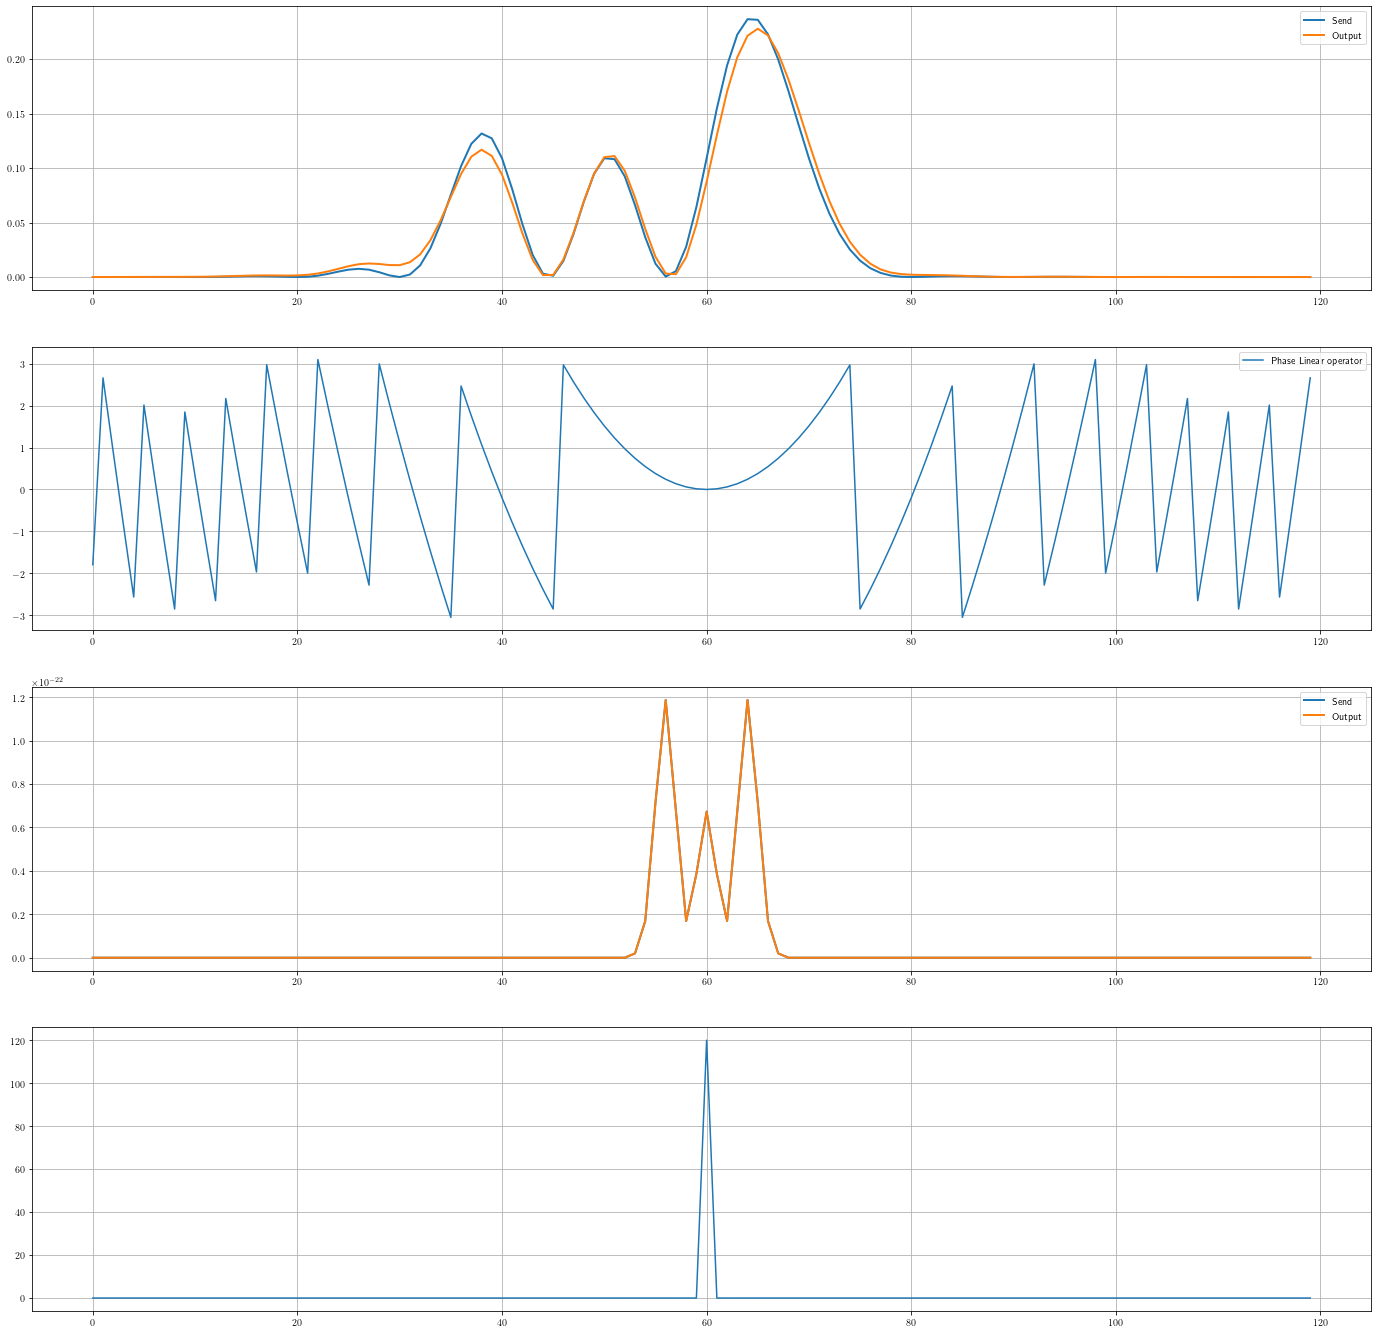

In [73]:
# Transmission
%run split_step_fourier.ipynb


z_length = 10  # [km]
nz = 2  # steps
dz = z_length / nz  # [km]

alpha = 0  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 0.5e-3 # [1/W/km]

output, linop, nonlinop = splitstepfourier(send_rc, t_sample_rc, dz, nz, alpha, beta2, gamma)

matplotlib.rc('figure', figsize=(24, 24))

plt.subplot(411)
plt.plot(np.square(abs(send_rc)), linewidth=2.0, label='Send')
plt.plot(np.square(abs(output)), linewidth=2.0, label='Output')

plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(np.fft.fftshift(np.angle(linop)), label='Phase Linear operator')

plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(np.fft.fftshift(np.square(abs(t_sample_gaussian*np.fft.fft(send_rc)/np.sqrt(2*np.pi)))), linewidth=2.0, label='Send')
plt.plot(np.fft.fftshift(np.square(abs(t_sample_gaussian*np.fft.fft(output)/np.sqrt(2*np.pi)))), linewidth=2.0, label='Output')

plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(np.fft.fftshift(np.fft.fft(nonlinop)))

plt.grid(True)
#plt.legend(loc='upper right')